# Spatial Data Assimilation in Geologic CO2 Sequestration
## Misael M. Morales - Summer 2023 - LANL

In [1]:
# Load packages, class, and functions
from utils import *
sda = spatialDA()
sda.check_torch_gpu()
octave = sda.mrst_startup()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: torchy | Python version: 3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1
Torch build with CUDA? True
# Device(s) available: 1, Name(s): Quadro P520

Welcome to the MATLAB Reservoir Simulation Toolbox (MRST)!
You are using the release version 2023a. To download other versions of MRST
and view examples and relevant publications, please visit www.mrst.no

Useful commands for getting started:
 - List all introductory examples:   mrstExamples()
 - List all modules:                 mrstPath('list')
 - Load modules using GUI:           mrstModule('gui')
 - Explore all available data sets:  mrstDatasetGUI()
 - List examples of a module:        mrstExamples('ad-blackoil')
 - Explore modules and publications: mrstExploreModules()
 - Show all examples in all modules: mrstExamples('all')
 - Show settings for MRST:           mrstSettings()
 

True Perm: (2601,) | True Saturation: (3, 2601)
Perm Ensemble: (100, 2601)
Perm All shape: (101, 2601)


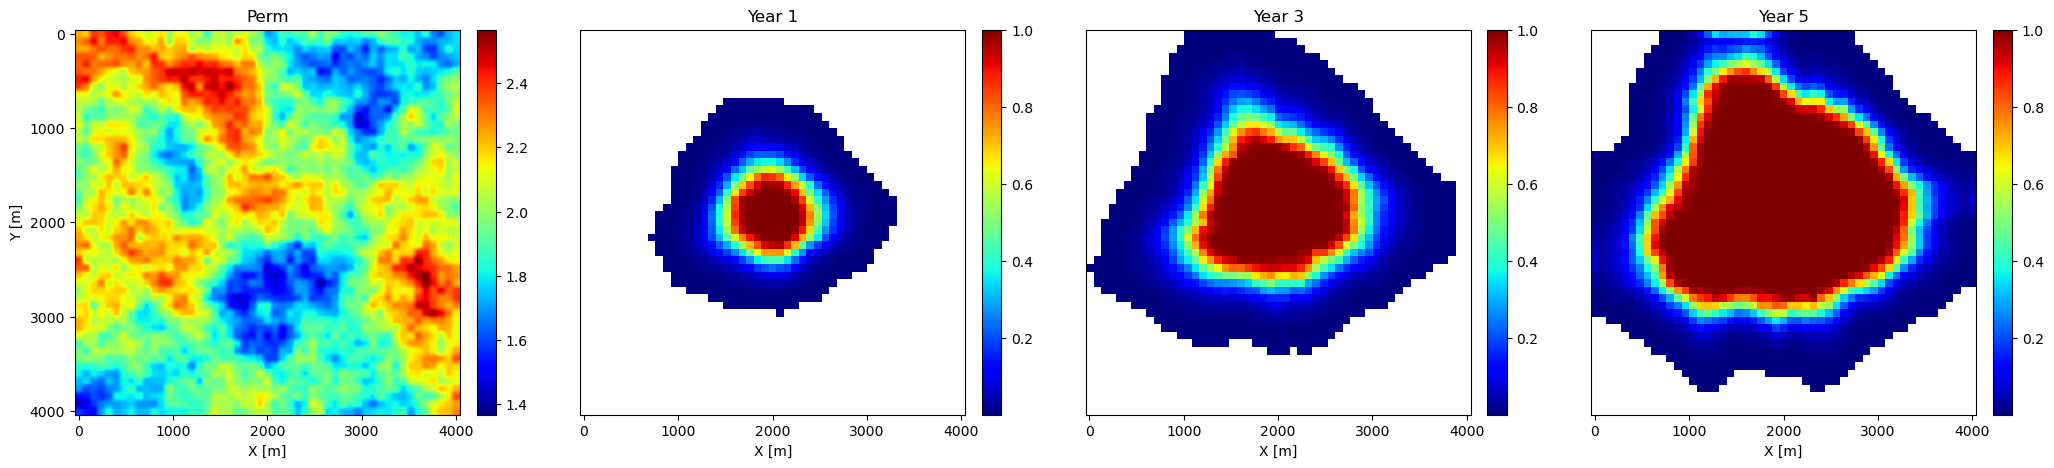

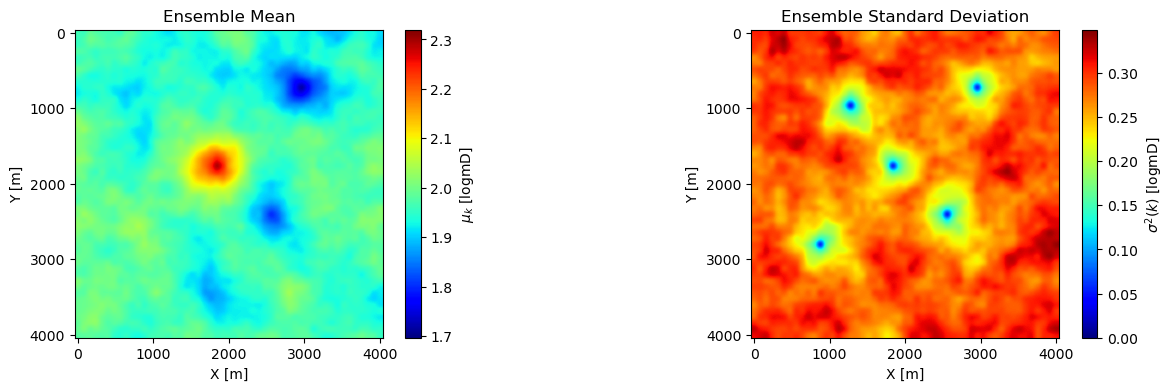

In [2]:
# Load permeability (true, ensemble) and saturation (true)
perm_true, sat_true = sda.load_perm_sat_true()
perm_ens            = sda.load_perm_ens()
perm_all            = sda.load_perm_all()
sat_true_bc         = np.load('true_sat_bc.npy')

sda.plot_perm_sat(perm_true, sat_true_bc)
sda.plot_ens_mean_std()

Solving timestep 01/10:         -> 11 Days, 9 Hours, 3354.75 Seconds
Solving timestep 02/10: 11 Days, 9 Hours, 3354.75 Seconds -> 22 Days, 19 Hours, 3109.50 Seconds
Solving timestep 03/10: 22 Days, 19 Hours, 3109.50 Seconds -> 45 Days, 15 Hours, 2619.00 Seconds
Solving timestep 04/10: 45 Days, 15 Hours, 2619.00 Seconds -> 91 Days, 7 Hours, 1638.00 Seconds
Solving timestep 05/10: 91 Days, 7 Hours, 1638.00 Seconds -> 182 Days, 14 Hours, 3276.00 Seconds
Solving timestep 06/10: 182 Days, 14 Hours, 3276.00 Seconds -> 1 Year
Solving timestep 07/10: 1 Year  -> 2 Years
Solving timestep 08/10: 2 Years -> 3 Years
Solving timestep 09/10: 3 Years -> 4 Years
Solving timestep 10/10: 4 Years -> 5 Years
*** Simulation complete. Solved 10 control steps in 37 Seconds, 233 Milliseconds ***
Simulation 0 Done!
Solving timestep 01/10:         -> 11 Days, 9 Hours, 3354.75 Seconds
Solving timestep 02/10: 11 Days, 9 Hours, 3354.75 Seconds -> 22 Days, 19 Hours, 3109.50 Seconds
Solving timestep 03/10: 22 Days, 1

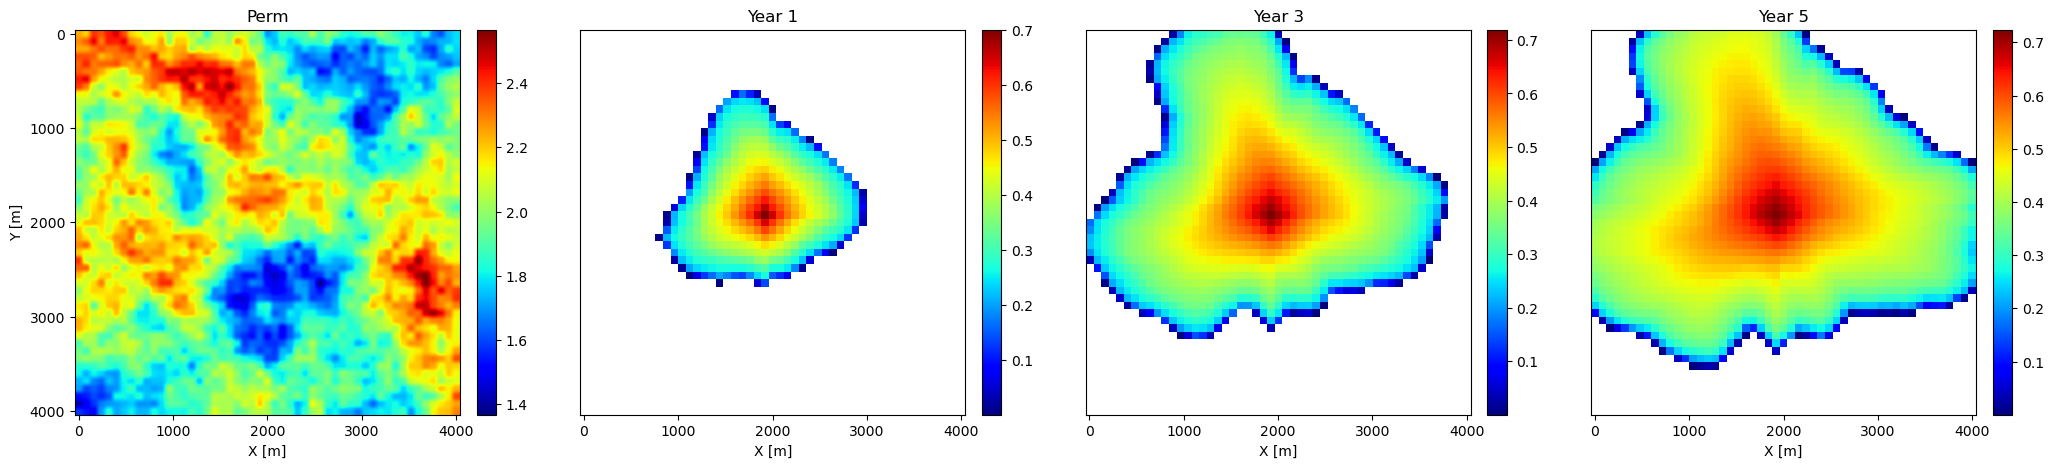

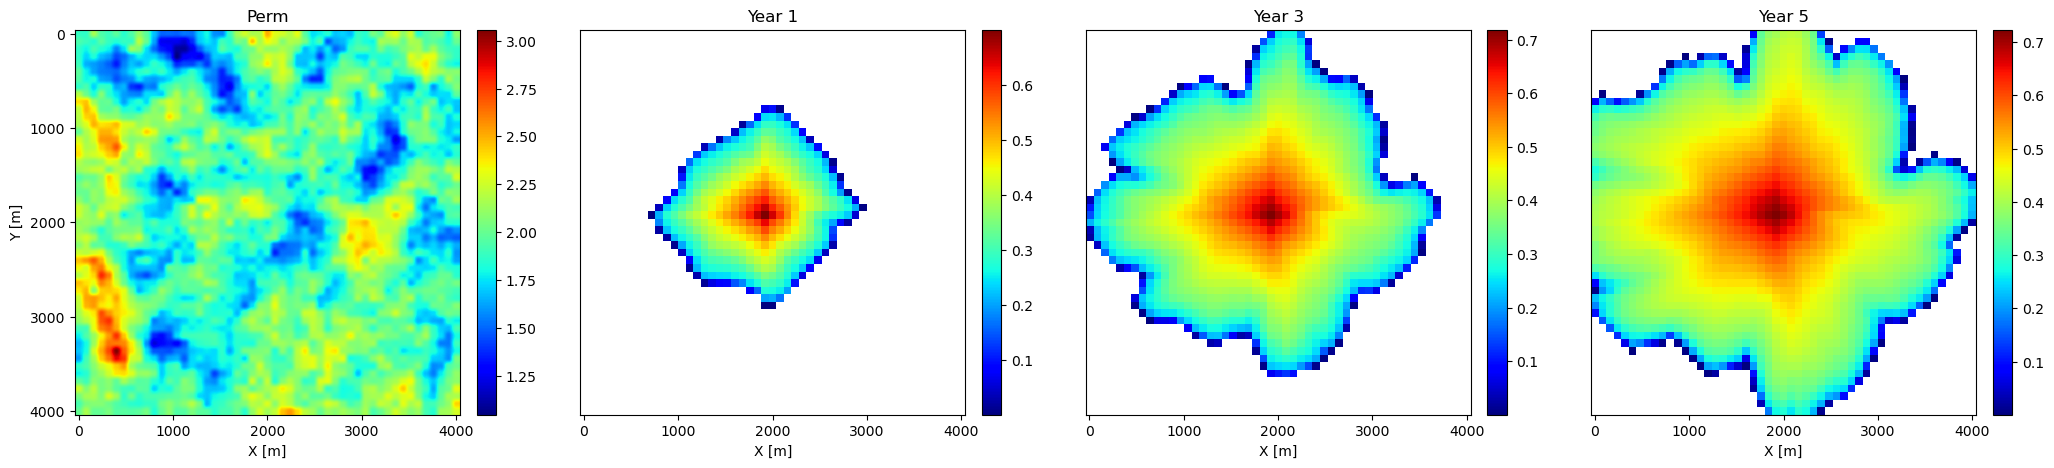

In [3]:
# Reservoir Simulation of the permeability ensemble
n_realizations = 5 #perm_ens.shape[0]

saturation = {}
for i in range(n_realizations):
    saturation[i] = octave.feval('simulations/resSim', perm_all[i])
    print('Simulation {} Done!'.format(i))

for i in range(2):
    sda.plot_perm_sat(perm_all[i], saturation[i])

***
### ESMDA-GEO

In [ ]:
def linear(p, x):
    return p[0]*np.exp(x*p[1])

def forward_model(m_ensemble, x):
    d_pred = np.zeros([m_ensemble.shape[0], x.shape[0]])
    for j in range(m_ensemble.shape[0]):
        d_pred[j, :] = linear(m_ensemble[j, :], x)
    return d_pred

a, b = 10.0, -0.002                                    # true parameters
x = np.arange(100)                                           # timesteps
obs = linear((a, b), x) + np.random.normal(0,1,x.shape[0])       # observations
cov_obs = np.diag([1.0] * obs.shape[0])                        # Observation error covariance matrix
print('obs: {} | cov_obs: {}'.format(obs.shape, cov_obs.shape))

n_ensemble = 100                                               # size of the ensemble
ma = np.random.uniform(low=-10.0, high=50.0, size=n_ensemble)  # Uniform law for the parameter a ensemble
mb = np.random.uniform(low=-0.001, high=0.01, size=n_ensemble) # Uniform law for the parameter b ensemble
m_ensemble = np.stack((ma, mb), axis=1)                        # Prior ensemble
print('m_ensemble: {}'.format(m_ensemble.shape))

n_assimilations = 3
# Use a geometric suite to compte alphas.
cov_obs_inflation_geo = 1.2
cov_obs_inflation_factors = [1.1]
for i in range(1, n_assimilations):
    cov_obs_inflation_factors.append(cov_obs_inflation_factors[i-1] / cov_obs_inflation_geo)
scaling_factor = np.sum(1 / np.array(cov_obs_inflation_factors))
cov_obs_inflation_factors = [alpha * scaling_factor for alpha in cov_obs_inflation_factors]
print('cov_obs_inflation_factors:', cov_obs_inflation_factors)
cov_mm_inflation_factors = [1.2] * n_assimilations       # This is just for the test
print('cov_mm_inflation_factors: ', cov_mm_inflation_factors)

solver = ESMDA(obs, m_ensemble, cov_obs, forward_model,
    forward_model_args        = (x,),
    forward_model_kwargs      = {},
    n_assimilations           = n_assimilations,
    cov_obs_inflation_factors = cov_obs_inflation_factors,
    cov_mm_inflation_factors  = cov_mm_inflation_factors,
    save_ensembles_history    = True)
solver.solve()

# Get the approximated parameters and uncertainty
a_approx, b_approx = np.average(solver.m_prior, axis=0)
a_std, b_std = np.sqrt(np.diagonal(solver.cov_mm))
print(f"a = {a_approx:.5f} +/- {a_std:.4E}")
print(f"b = {b_approx:.5f} +/- {b_std: 4E}")

posterior = np.zeros((n_ensemble, x.shape[0]))
for i in range(n_ensemble):
    posterior[i,:] = linear(solver.m_prior[i], np.arange(x.shape[0]))

prior = np.zeros((n_ensemble,x.shape[0]))
for i in range(n_ensemble):
    prior[i] = linear(m_ensemble[i], np.arange(x.shape[0]))
 
plt.figure()
for i in range(n_ensemble):
    plt.plot(np.arange(x.shape[0]), prior[i], 'c-', alpha=0.2)
    plt.plot(np.arange(x.shape[0]), obs, 'k-')
    plt.plot(np.arange(x.shape[0]), posterior[i], 'r--')
plt.show()

In [72]:
# Ensemble
n_ensemble = 2
m_ensemble = perm_ens[:n_ensemble]
print('m_ensemble: {}'.format(m_ensemble.shape))

# Observations
obs     = sat_true_bc[0]
cov_obs = np.diag([1.0] * obs.shape[0])     #approximate_cov_mm(obs)
print('obs: {} | cov_obs: {}'.format(obs.shape, cov_obs.shape))

m_ensemble: (2, 2601)
obs: (2601,) | cov_obs: (2601, 2601)


In [73]:
n_assimilations = 4

cov_obs_inflation_geo = 1.2
cov_mm_inflation_geo  = 1.2

cov_obs_inflation_factors = [1.1]
for i in range(1, n_assimilations):
    cov_obs_inflation_factors.append(cov_obs_inflation_factors[i-1] / cov_obs_inflation_geo)
scaling_factor = np.sum(1/np.array(cov_obs_inflation_factors))
cov_obs_inflation_factors = [alpha * scaling_factor for alpha in cov_obs_inflation_factors]
print('cov_obs_inflation_factors:', cov_obs_inflation_factors)

cov_mm_inflation_factors = [cov_mm_inflation_geo] * n_assimilations
print('cov_mm_inflation_factors: ', cov_mm_inflation_factors)

cov_obs_inflation_factors: [17.0, 1.0625]
cov_mm_inflation_factors:  [4, 4]


In [84]:
def forward_model(ens):
    d_pred = np.zeros([n_ensemble, sda.dim*sda.dim])
    for i in range(ens.shape[0]):
        sat_pred = octave.feval('simulations_octave/resSim', ens[i])[0,:]
        d_pred[i,:] = np.moveaxis(sat_pred,0,-1)
    return d_pred

In [85]:
solver = ESMDA(obs=obs, m_init=m_ensemble, cov_obs=cov_obs, 
               forward_model             = forward_model,
               forward_model_args        = (),
               forward_model_kwargs      = {},
               n_assimilations           = n_assimilations,
               cov_obs_inflation_factors = cov_obs_inflation_factors,
               cov_mm_inflation_factors  = cov_mm_inflation_factors,
               save_ensembles_history    = True)
solver.solve()

Assimilation # 1


Solving timestep 01/10:         -> 11 Days, 9 Hours, 3354.75 Seconds
Solving timestep 02/10: 11 Days, 9 Hours, 3354.75 Seconds -> 22 Days, 19 Hours, 3109.50 Seconds
Solving timestep 03/10: 22 Days, 19 Hours, 3109.50 Seconds -> 45 Days, 15 Hours, 2619.00 Seconds
Solving timestep 04/10: 45 Days, 15 Hours, 2619.00 Seconds -> 91 Days, 7 Hours, 1638.00 Seconds
Solving timestep 05/10: 91 Days, 7 Hours, 1638.00 Seconds -> 182 Days, 14 Hours, 3276.00 Seconds
Solving timestep 06/10: 182 Days, 14 Hours, 3276.00 Seconds -> 1 Year
Solving timestep 07/10: 1 Year  -> 2 Years
Solving timestep 08/10: 2 Years -> 3 Years
Solving timestep 09/10: 3 Years -> 4 Years
Solving timestep 10/10: 4 Years -> 5 Years
*** Simulation complete. Solved 10 control steps in 96 Seconds, 771 Milliseconds ***
Solving timestep 01/10:         -> 11 Days, 9 Hours, 3354.75 Seconds
Solving timestep 02/10: 11 Days, 9 Hours, 3354.75 Seconds -> 22 Days, 19 Hours, 3109.50 Seconds
Solving timestep 03/10: 22 Days, 19 Hours, 3109.50 Se

In [110]:
np.array(solver.d_history).shape

(3, 2, 2601)

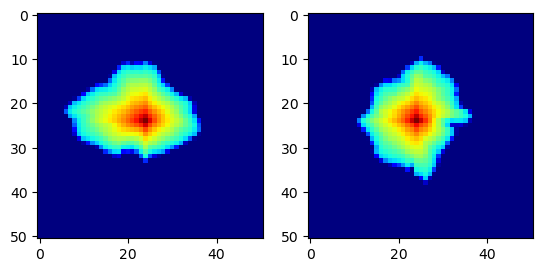

In [120]:
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(solver.d_pred[i].reshape(51,51), 'jet')

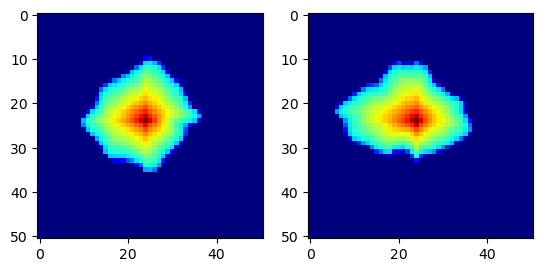

In [127]:
sat_ens = loadmat('simulations/sat_ens.mat')['sat']
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(sat_ens[i,0].reshape(51,51), 'jet')

***
# END

In [199]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [200]:
reg = Ridge()
reg.fit(perm_ens, sat_ens[:,0])
y_pred = reg.predict(perm_ens)
y_pred.shape

(100, 2601)

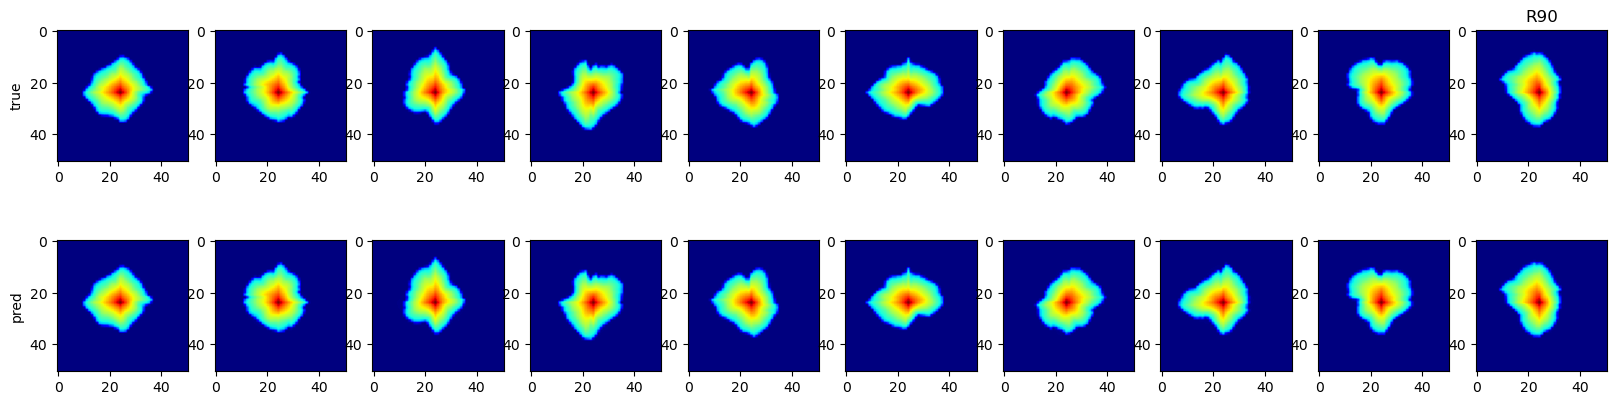

In [201]:
fig, axs = plt.subplots(2, 10, figsize=(20,5))
for i in range(10):
    k = i*10
    axs[0,i].imshow(sat_ens[k,0].reshape(51,51), 'jet'); axs[0,0].set(ylabel='true')
    axs[1,i].imshow(y_pred[k].reshape(51,51), 'jet');    axs[1,0].set(ylabel='pred')
    axs[0,j].set(title='R{}'.format(k))

In [202]:
alpha = [0.30102010e2, 0.11233479e2, 0.41921135e1, 0.15644144e1]
alpha

[30.10201, 11.233479, 4.1921135, 1.5644144]

In [203]:
# Ensemble
m_ensemble = perm_ens
print('m_ensemble: {}'.format(m_ensemble.shape))

# Observations
obs     = sat_true_bc[0]
cov_obs = np.diag([1.0] * obs.shape[0])     #approximate_cov_mm(obs)
print('obs: {} | cov_obs: {}'.format(obs.shape, cov_obs.shape))

n_assimilations = 10

cov_obs_inflation_geo = 1.2
cov_mm_inflation_geo  = 1.2
cov_obs_inflation_factors = [1.1]
for i in range(1, n_assimilations):
    cov_obs_inflation_factors.append(cov_obs_inflation_factors[i-1] / cov_obs_inflation_geo)
scaling_factor = np.sum(1/np.array(cov_obs_inflation_factors))
cov_obs_inflation_factors = [alpha * scaling_factor for alpha in cov_obs_inflation_factors]
cov_mm_inflation_factors = [cov_mm_inflation_geo] * n_assimilations

cov_obs_inflation_factors = alpha
cov_mm_inflation_factors  = alpha
print('cov_obs_inflation_factors:', cov_obs_inflation_factors)
print('cov_mm_inflation_factors: ', cov_mm_inflation_factors)

def forward_model(ens):
    return reg.predict(ens)

solver = ESMDA(obs=obs, m_init=m_ensemble, cov_obs=cov_obs, 
               forward_model             = forward_model,
               forward_model_args        = (),
               forward_model_kwargs      = {},
               n_assimilations           = n_assimilations,
               cov_obs_inflation_factors = cov_obs_inflation_factors,
               cov_mm_inflation_factors  = cov_mm_inflation_factors,
               save_ensembles_history    = True)
solver.solve()

m_ensemble: (100, 2601)
obs: (2601,) | cov_obs: (2601, 2601)
cov_obs_inflation_factors: [30.10201, 11.233479, 4.1921135, 1.5644144]
cov_mm_inflation_factors:  [30.10201, 11.233479, 4.1921135, 1.5644144]
Assimilation # 1
Assimilation # 2
Assimilation # 3
Assimilation # 4


(5, 100, 2601)


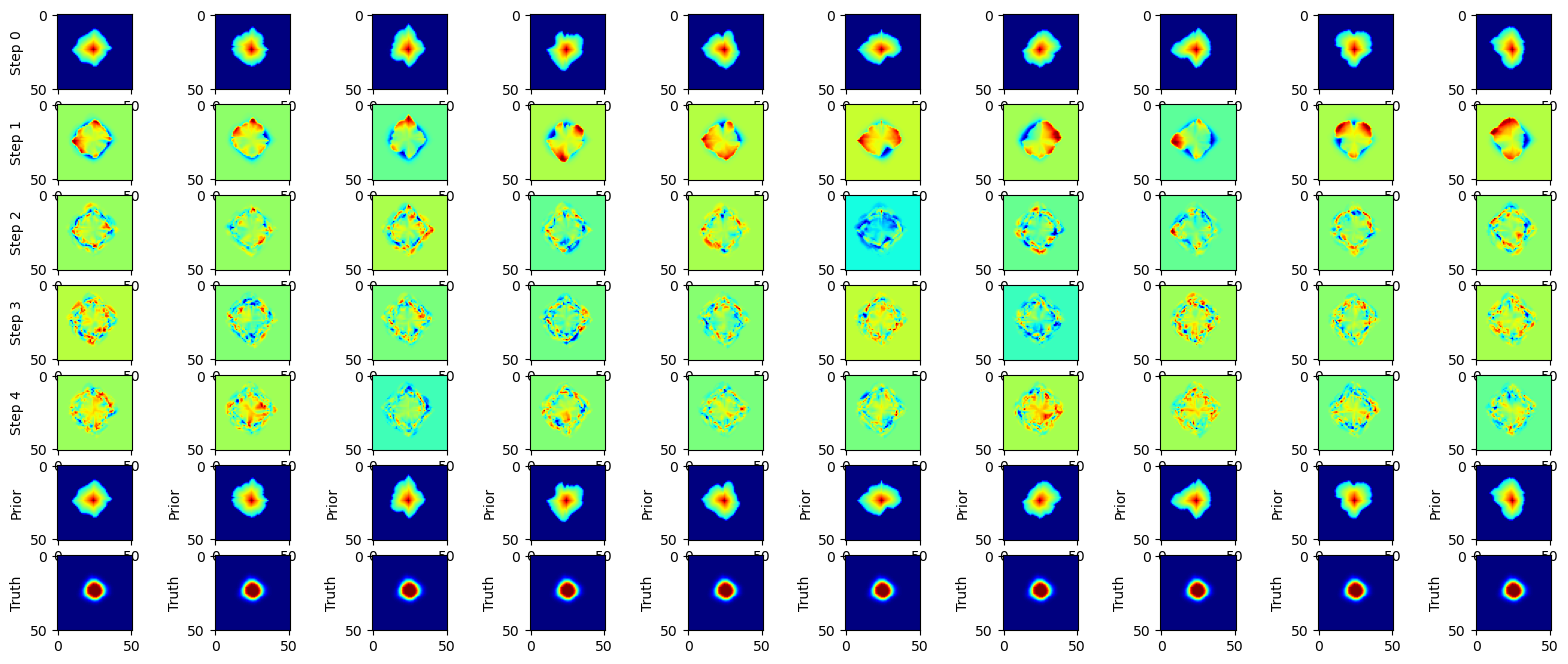

In [220]:
temp = np.array(solver.d_history)
print(temp.shape)

fig, axs = plt.subplots(7, 10, figsize=(20,8))
for i in range(5):
    for j in range(10):
        k = j*10
        axs[i,j].imshow(temp[i,k].reshape(51,51), 'jet')
        axs[i,0].set(ylabel='Step {}'.format(i))
        axs[5,j].imshow(sat_ens[k,0].reshape(51,51), 'jet'); axs[5,j].set(ylabel='Prior')
        axs[6,j].imshow(sat_true_bc[0].reshape(51,51),'jet');    axs[6,j].set(ylabel='Truth')

(5, 100, 2601)


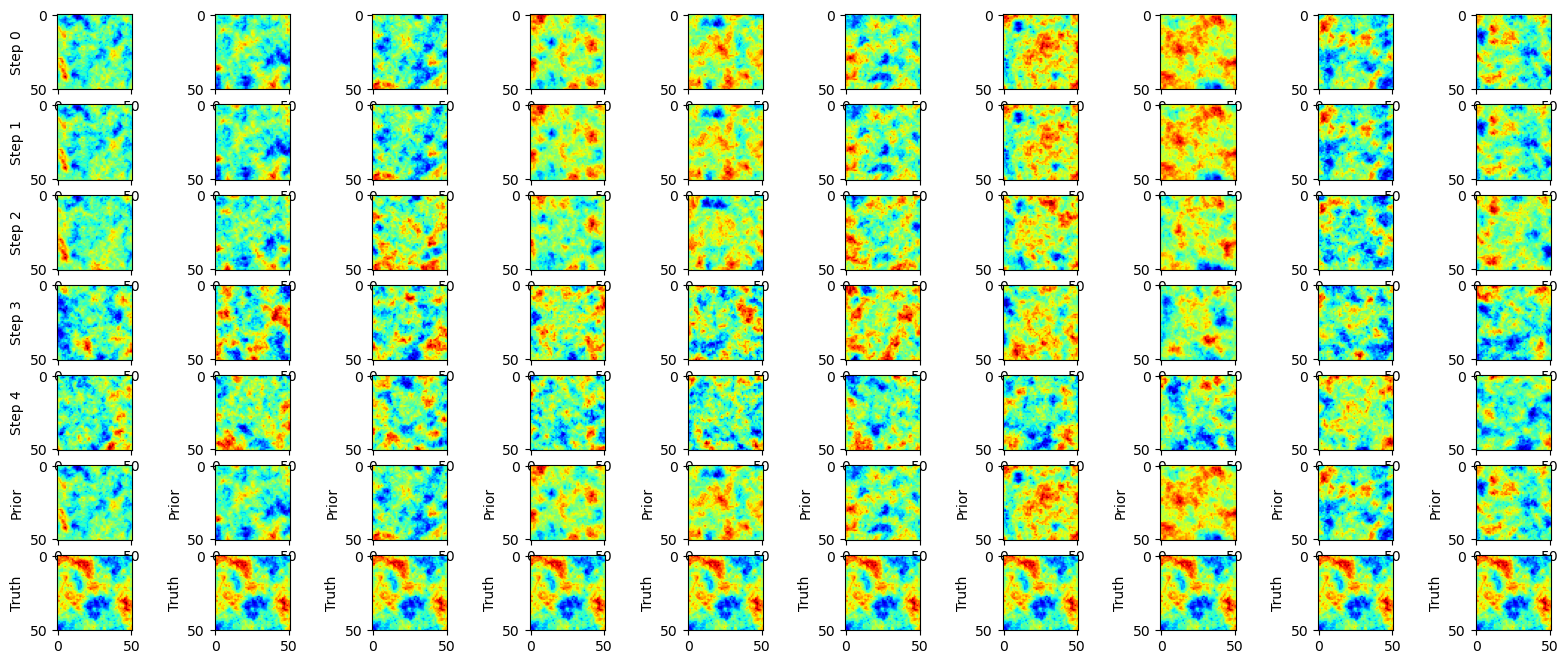

In [211]:
temp = np.array(solver.m_history)
print(temp.shape)

fig, axs = plt.subplots(7, 10, figsize=(20,8))
for i in range(5):
    for j in range(10):
        k = j*10
        axs[i,j].imshow(temp[i,k].reshape(51,51), 'jet')
        axs[i,0].set(ylabel='Step {}'.format(i))
        axs[5,j].imshow(perm_ens[k].reshape(51,51), 'jet'); axs[5,j].set(ylabel='Prior')
        axs[6,j].imshow(perm_true.reshape(51,51),'jet');    axs[6,j].set(ylabel='Truth')